# Overview

We left off in 9.1 with our t-tests having issues with non-normal data. Traditional stats have lots of options for you here with things like transforming your data to be normal or using non-parametric tests. 

But, we have computers and computers can do math fast. Why use tests that assume normality to estimate a probability when you can brute force the probability?  Remember, your standard statistical tests are returning a p-value that is trying to get at the odds this could have happneed by chance. So, if you drew `nsamples` from setA and `nsamples` from setB, it's trying (by assuming a shape of a distribution) to calculate, if they really came from the same pool, how often you'd observe data as cool as your data.

We take this logic then and exploit it a bit. You have some set of observations and you know which came from setA and which from setB. You think that that secret-decoder-ring is cool (the decoder that assign certain numbers to setA and others to setB). A **permutation test** says "If I permuted my labels to generate every possible setA and setB from my data (all possible re-labeling of points) and computed the difference between means each time, I could determine just how cool my set of lables (secret decoder ring) really is.". So, if your assignment of data points to setA vs. setB is better than 99.9% of all possible assignments, that makes yours pretty cool - pretty darn unlikely to occur by chance. In fact, your odds of something as cool as your set of labels or cooler is 0.001 in that case. Exactly that. It's an exact test of the probability we're after.

When sample sizes are modest, we can run full permutations. Here's a bit of code that will compute just how many are needed.

In [1]:
import itertools
import numpy as np
from math import factorial

npergroup=10
ntotal=npergroup*2
groups=np.mod(np.arange(ntotal),2)
print(f"We have {np.sum(groups==0)} in one group and {np.sum(groups==1)} in the other")
ncombos=factorial(ntotal) / (factorial(npergroup) * factorial(ntotal-npergroup))
print(f"We then have a total of {ncombos:.0f} combinations")

all_combos=list(itertools.combinations(groups,npergroup))
print(f"Or, computed another way ... (hint hint) {len(all_combos)} combinations")


We have 10 in one group and 10 in the other
We then have a total of 184756 combinations
Or, computed another way ... (hint hint) 184756 combinations


# Get the data
For this next bit, we're going to use some datasets I've already made. I used my code for `GenNormalSamples` to make up some data for us, so that we're all working on the same input. I've got a few ways you can get / load the data for this.  First, you can just download it from the class [GitHub repository](https://github.com/celstark/n247data). It's the Orig*.csv set there.  If you're working in a local Jupyter notebook, this may be the easiest way. Stick that in your folder here and you can use the normal Pandas functions to read CSV files just fine.

Second, though, you can save these files into a Google Drive and load them from here. This is particularly relevant if you're running things on Google Colab.  Third, you can pull them straight from the GitHub repo as you run the code.  

Samples of how to do the last two options are here. Note `np.loadtxt` and `np.genfromtxt` only differ in how they handle missing values.

In [2]:
# Loading the files from your Google Drive if you're using Colab and have copied files to your drive (edit as needed to change the actual location)
# from google.colab import drive
import os
import numpy as np
# drive.mount('/content/gdrive')
# This can be a personal drive, a shared drive, etc.  Point it to the folder here
# studydir='/content/gdrive/My Drive/N247_2023'
# os.chdir(studydir)  

# OrigSkew=np.loadtxt('OrigSkew.csv')
# OrigNorm=np.loadtxt('OrigNorm.csv')
# OrigNullSkew=np.loadtxt('OrigNullSkew.csv')
# OrigNullNorm=np.loadtxt('OrigNullNorm.csv')

In [3]:
# Loading the files from GitHub directly
import numpy as np

OrigNorm = np.loadtxt('https://github.com/celstark/n247data/raw/main/data/OrigNorm.csv')
OrigSkew = np.loadtxt('https://github.com/celstark/n247data/raw/main/data/OrigSkew.csv')
OrigNullNorm = np.loadtxt('https://github.com/celstark/n247data/raw/main/data/OrigNullNorm.csv')
OrigNullSkew = np.loadtxt('https://github.com/celstark/n247data/raw/main/data/OrigNullSkew.csv')


Now that you've got the data, you're going to write both a permutation test and a Monte Carlo analysis of the data. As described above, permutation tests run all possible permutations of the groupings and are great when that number isn't crazy. When that number gets to be too big, we approximate it via a **Monte Carlo** analysis. This just means, we do a random sampling of those permutations and, if that sampling is really random and of a decent size, we can estimate our proabability just fine.  It sounds fancy, but yea - it's just a random sampling of the permutations.

For this next bit, though, we only have 185k possible permutations and this should take just a few seconds to run them all.  So, in this next bit, you'll write a function `PermutationTest` that iterates over all permutations of putting half (10) of the observations in one group and the other half (10) in the other group.  So, for each iteration, compute the mean in each group, compute the difference between these, and store that in an array. If you want this to run before you graduate, make sure to pre-allocate your results array and don't use `append` each time through your loop.

At the end, return the percentile for the original group-assignment difference. If, for example, your original difference in means was 5 and there were 2340 values in your "all differences" array that were greater than 5, the percentile would be 2340/184756 or 0.0127 when considered "one-tailed".  To make this a two-tailed test, you'd take the absolute value of the original difference and count how many times the absolute value of your "all differences" array was greater than this, dividing again by the total number of permutations.  (Note, when doing things one-tailed, consider handling positive and negative original differences intelligently).

Here are target numbers for the *OrigNullNorm* dataset:
```
Original difference 0.30
t-test p=0.563
Permutaton p=0.559
```
Run on all 4 datasets (*OrigNullNorm*, *OrigNullSkew*, *OrigNorm*, and *OrigSkew*). When getting going, you'll want to comment out all but one of the actual analysis bits.  The numbers above for OrigNullNorm should help you know if you're working. I've included a little plot routine as well that lets you look at the distribution of differences. This is also my plot for the *OrigNullNorm* and *OrigSkew* datasets.

| ![sample output](https://github.com/celstark/n247data/raw/main/data/stats_perm_fig3a.png)       | ![sample output](https://github.com/celstark/n247data/raw/main/data/stats_perm_fig3b.png)    | 


Null, normal p=0.559

Null effect, skew p=0.048

Effect, normal p=0.000

Effect, skew p=0.038



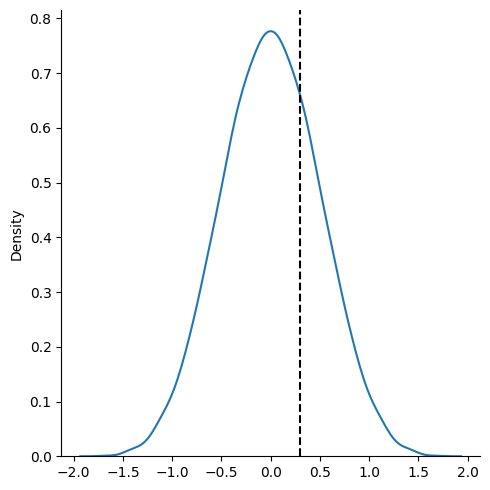

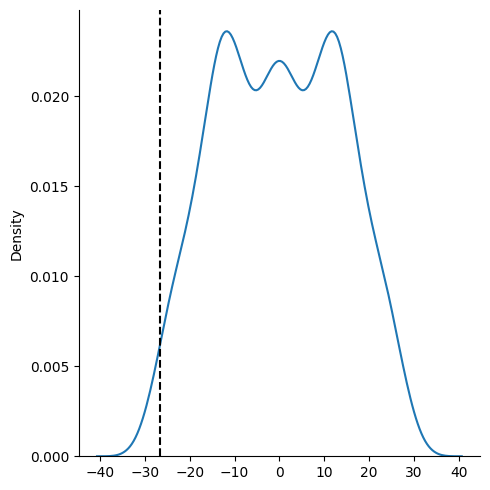

In [24]:
from scipy.stats import ttest_ind
import itertools
from math import factorial
import numpy as np
import seaborn as sns
def PermutationPlot(all_diffs, orig_diff=None):
    # Handy function to plot the output of your PertmutationTest call
    g=sns.displot(all_diffs,kind='kde')
    if orig_diff:
        g.refline(x=orig_diff,color='k')

def PermutationTest(data,tails=2,verbose=False):
    '''iterates over all permutations of putting half (10) of the observations in one group 
    and the other half (10) in the other group.  So, for each iteration, compute the mean in each group,
      compute the difference between these, and store that in an array (orig_diff).
       return the percentile for the original group-assignment difference (p_tile).  
At the end, return the percentile for the original group-assignment difference. 
If, for example, your original difference in means was 5 and there were 2340 values in your "all differences" array that were greater than 5,
 the percentile would be 2340/184756 or 0.0127 when considered "one-tailed".  To make this a two-tailed test, you'd take the absolute value of 
 the original difference and count how many times the absolute value of your "all differences" array was greater than this, dividing again by the 
   total number of permutations. ''' 
    
    npergroup=data.shape[0]
    ntotal=data.shape[0]* data.shape[1] 
    orig_diff = np.mean(data[:,0]-data[:,1])
    flattened = data.flatten()
    all_combinations = list(itertools.combinations(range(len(flattened)), npergroup))

    #get idx for group 1 and group 2 from all_combinations list. then compute difference in means between the groups.
    #whatever idx were used in group1 cannot be assigned to group 2. 
    all_diffs = [np.mean(flattened[list(idx)]) - np.mean(flattened[[i for i in range(len(flattened)) if i not in idx]])for idx in all_combinations]
   
    bigger = 0
    for n in all_diffs: 
        if abs(n) > abs(orig_diff):
            bigger += 1 
    
    ptile = bigger / len(all_combinations)

    return ptile,orig_diff,all_diffs


# Start by commenting out all but one of these analyses until you've got things going.
ptile,orig_diff,all_diffs=PermutationTest(OrigNullNorm)
print(f'Null, normal p={ptile:.3f}\n')
PermutationPlot(all_diffs,orig_diff)

ptile,orig_diff,all_diffs=PermutationTest(OrigNullSkew)
print(f'Null effect, skew p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=PermutationTest(OrigNorm)
print(f'Effect, normal p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=PermutationTest(OrigSkew)
print(f'Effect, skew p={ptile:.3f}\n')
PermutationPlot(all_diffs,orig_diff)



# Monte Carlo version
Well, 185k isn't so crazy for this kind of thing, but what if we needed a lot more math than just a simple difference? What if each iteration then took several seconds?  Or, what if we have larger samples than two groups of 10?  The time it takes to run a full permutation can get out of hand quickly.

Just as we can approximate how a population behaves by sampling it (the fundamental idea in all of statistics), we can approximate how our measure behaves by sampling it rather than by testing every possible point. That's what we do in a Monte Carlo analysis.

Here, re-write your code to just randomly shuffle the groups `nshuffles` times (default 1000), compute the difference each time and return the same percentile and "all differences" array as before. This should be a plug-in replacement for your `PermutationTest()` routine.  Run on all 4 datasets and you should see the p-values are darn close, even with the default of 1000 samples.


In [25]:
from scipy.stats import ttest_ind
import numpy as np

def MonteCarloTest(data,nshuffles=1000,tails=2,verbose=False):
    orig_diff = np.mean(data[:,0]-data[:,1])
    group1 = data[:,0]
    group2 = data[:,1]
    
    all_diffs = [np.mean(np.random.permutation(group1))-np.mean(np.random.permutation(group2)) for _ in range(nshuffles+1)]

    bigger = 0
    for n in all_diffs: 
        if abs(n) > abs(orig_diff):
            bigger += 1 
    
    ptile = bigger / nshuffles

    return ptile,orig_diff,all_diffs

ptile,orig_diff,all_diffs=MonteCarloTest(OrigNullNorm)
print(f'Null, normal p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=MonteCarloTest(OrigNullSkew)
print(f'Null effect, skew p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=MonteCarloTest(OrigNorm)
print(f'Effect, normal p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=MonteCarloTest(OrigSkew)
print(f'Effect, skew p={ptile:.3f}\n')

Null, normal p=0.323

Null effect, skew p=0.948

Effect, normal p=0.743

Effect, skew p=0.039

